# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy import stats as st

            Загрузим данные и посмотрим на них.

In [2]:
reg_0 = pd.read_csv('geo_data_0.csv')
reg_1 = pd.read_csv('geo_data_1.csv')
reg_2 = pd.read_csv('geo_data_2.csv')

In [3]:
reg_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [4]:
reg_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
reg_0.duplicated().sum()

0

In [6]:
len(reg_0['id'].unique())

99990

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CCD9D08D08>,
      dtype=object)

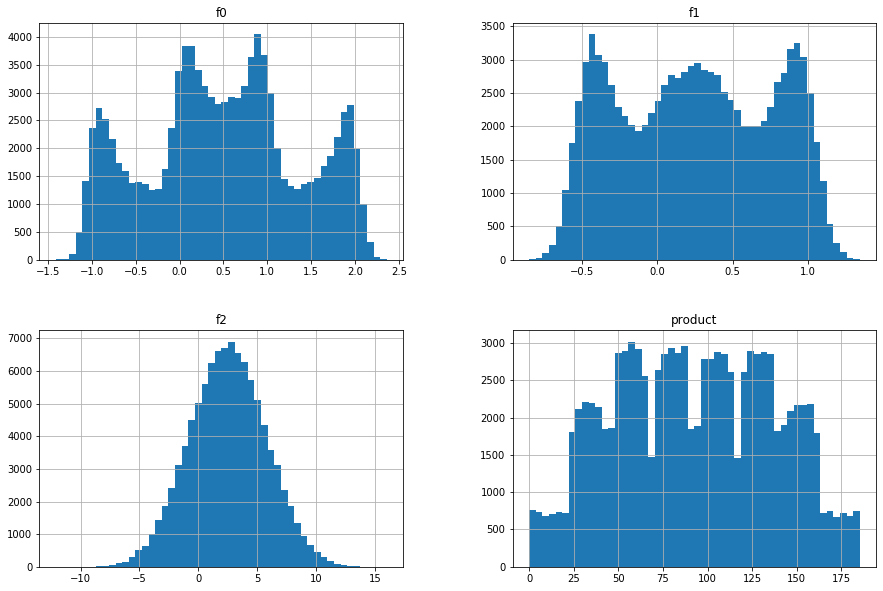

In [7]:
reg_0.hist(bins=50, figsize=(15, 10))

        Многогорбые распределения.
        Пропусков в данных нет.
        Есть дубликаты ID скважин, при совещании с руководителем программы (наш коуч в Slack'е) 
        было решено, что нужно их проигнорировать.

In [8]:
reg_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
reg_1.duplicated().sum()

0

In [10]:
reg_1['id'].duplicated().sum()

4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CCDBC7D648>,
      dtype=object)

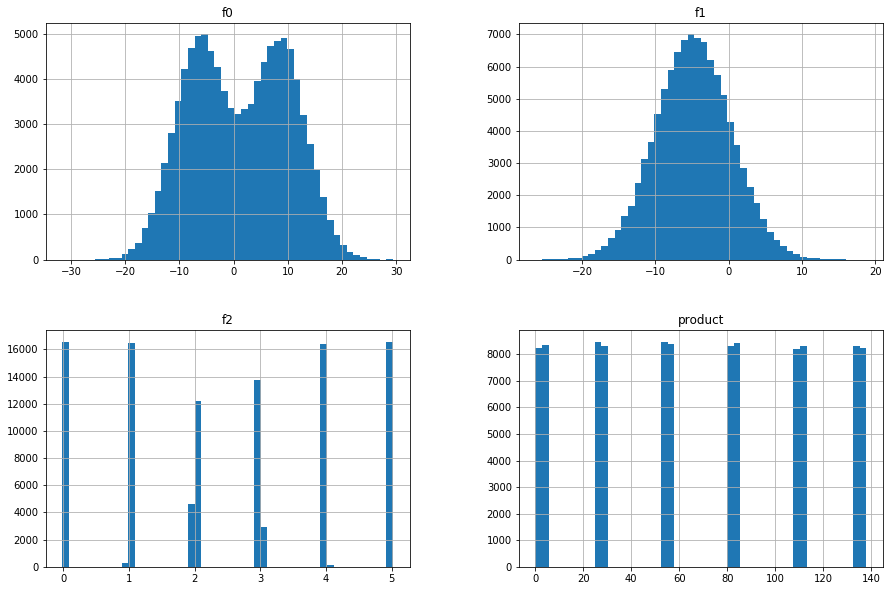

In [11]:
reg_1.hist(bins=50, figsize=(15, 10))

In [12]:
reg_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
reg_2.duplicated().sum()

0

In [14]:
reg_2['id'].duplicated().sum()

4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CCDC270EC8>,
      dtype=object)

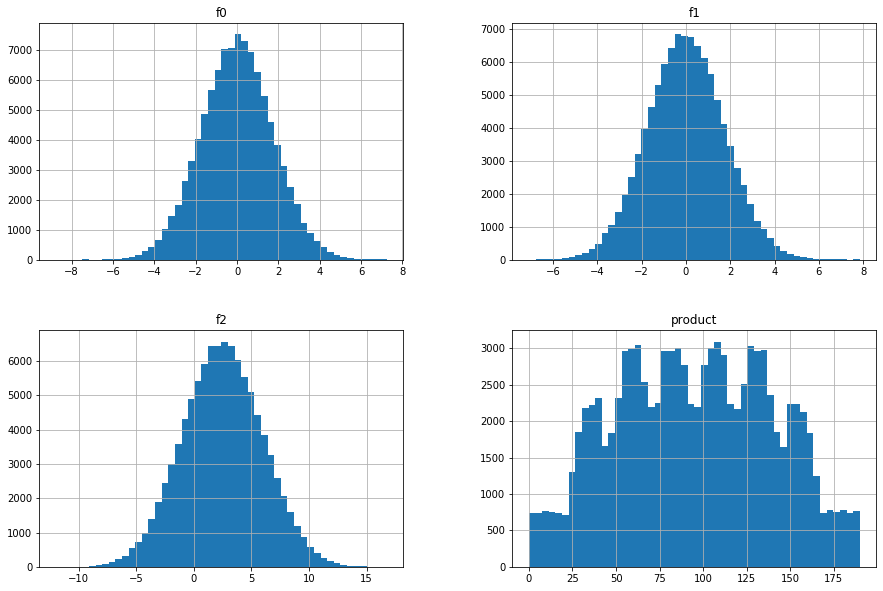

In [15]:
reg_2.hist(bins=50, figsize=(15, 10))

    Мы увидели разные распределения.
    Засекли повторы в ID скважин, но их крайне малое значение, максимум - 10шт. в регионе 1. Поэтому их даже можно не удалять.
    Заметили, что признаки не однородны и требуют масштабирования.

В дальнейшей работе нам не понадобятся ID скважин, и более того, нам нужны данные сторого без ID, поэтому удалим их, сохранив в новой переменной остаток.

In [16]:
df_0 = reg_0.drop('id', axis=1)
df_1 = reg_1.drop('id', axis=1)
df_2 = reg_2.drop('id', axis=1)

# 2. Обучение и проверка модели

    В этом шаге мы обучим и проверим модели для каждого региона.
    Сохраним предсказания наших моделей на валидационной выборке.

__1.__

Разбиваю данные на обучающую и валидационную выборки в соотношении 75:25.

        Для этого отделим целевое значение от остальных признаков.

In [17]:
features_0 = df_0.drop('product', axis=1)
target_0 = df_0['product']

features_1 = df_1.drop('product', axis=1)
target_1 = df_1['product']

features_2 = df_2.drop('product', axis=1)
target_2 = df_2['product']

    Непосредственное разделение на обучающую и валидационную выборки в соотношении 75 к 25.

        для региона 1

In [18]:
train_features_0, valid_features_0, train_target_0, valid_target_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=123)

In [19]:
train_features_0.shape, valid_features_0.shape, train_target_0.shape, valid_target_0.shape

((75000, 3), (25000, 3), (75000,), (25000,))

        для региона 2

In [20]:
train_features_1, valid_features_1, train_target_1, valid_target_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=123)

In [21]:
train_features_1.shape, valid_features_1.shape, train_target_1.shape, valid_target_1.shape

((75000, 3), (25000, 3), (75000,), (25000,))

        для региона 3

In [22]:
train_features_2, valid_features_2, train_target_2, valid_target_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=123)

In [23]:
train_features_2.shape, valid_features_2.shape, train_target_2.shape, valid_target_2.shape

((75000, 3), (25000, 3), (75000,), (25000,))

__2.__

проведем стандартизацию признаков для уравнения их значимости перед моделью.

            перед этим определим признаки, которые будем масштабировать

In [24]:
numeric = ['f0', 'f1', 'f2']

    для этого на тренировочных выборках обучим наш scaler

In [25]:
scaler_0 = StandardScaler()
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()

In [26]:
scaler_0.fit(train_features_0[numeric])

scaler_1.fit(train_features_1[numeric])

scaler_2.fit(train_features_2[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

    теперь проведем масштабирование валидационной и тестовой выборок

            для региона 1

In [27]:
train_features_0[numeric] = scaler_0.transform(train_features_0)
valid_features_0[numeric] = scaler_0.transform(valid_features_0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

            для региона 2

In [28]:
train_features_1[numeric] = scaler_1.transform(train_features_1)
valid_features_1[numeric] = scaler_1.transform(valid_features_1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

            для региона 3

In [29]:
train_features_2[numeric] = scaler_2.transform(train_features_2)
valid_features_2[numeric] = scaler_2.transform(valid_features_2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Подготовив данные для обучения модели на них - разбили данные на тренировочную и валидационную выборки в необходимом соотношении (75:25), провели масштабирование признаков. Приступаем к обучении модели.


__3.__

Обучим модель, чтобы сделать предсказания на валидационной выборке для каждого региона. Сохраним прогноз моделей и верный результат в один датафрейм.

    Моделью выберем - линейную регрессию, линейную, т.к. имеем дело с числами, а не с категориальными данными, регрессию - как наиболее предсказуемая.

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
model_0 = LinearRegression()
model_1 = LinearRegression()
model_2 = LinearRegression()

In [32]:
model_0.fit(train_features_0, train_target_0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
model_1.fit(train_features_1, train_target_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
model_2.fit(train_features_2, train_target_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

    модели обучены, далее получим их прогноз на валидационных выборках.

In [35]:
pred_0 = model_0.predict(valid_features_0)

In [36]:
pred_1 = model_1.predict(valid_features_1)

In [37]:
pred_2 = model_2.predict(valid_features_2)

    сохраним полученные прогнозы с верными ответами. Понадобятся в шаге 5.

In [38]:
answers_0 = pd.DataFrame()
answers_0['true_product'] = valid_target_0.reset_index(drop=True)
answers_0['predict_product'] = pred_0

In [39]:
answers_1 = pd.DataFrame()
answers_1['true_product'] = valid_target_1
answers_1['predict_product'] = pred_1

In [40]:
answers_2 = pd.DataFrame()
answers_2['true_product'] = valid_target_2
answers_2['predict_product'] = pred_2

__4.__

Далее посмотрим на RMSE моделей и средний запас предсказанного сырья по регионам.

In [41]:
rmse_0 = mean_squared_error(valid_target_0, pred_0)**0.5
rmse_0

37.64786282376176

In [42]:
rmse_1 = mean_squared_error(valid_target_1, pred_1)**0.5
rmse_1

0.8954139804944302

In [43]:
rmse_2 = mean_squared_error(valid_target_2, pred_2)**0.5
rmse_2

40.12803006598514

        средний запас сырья предсказанный моделью - pred_mean_product.
        
        средний запас сырья на самом деле - real_mean_product.

In [44]:
pred_mean_product_0 = pred_0.mean()
real_mean_product_0 = valid_target_0.mean()
real_median_product_0 = valid_target_0.median()

print('средний запас сырья предсказанный моделью региона 1:', pred_mean_product_0)
print('средний запас сырья на самом деле региона 1: ', real_mean_product_0)
print('медиана запасов сырья региона 1: ', real_median_product_0)

средний запас сырья предсказанный моделью региона 1: 92.54936189116306
средний запас сырья на самом деле региона 1:  92.85062391123498
медиана запасов сырья региона 1:  92.37279560350052


In [45]:
pred_mean_product_1 = pred_1.mean()
real_mean_product_1 = valid_target_1.mean()
real_median_product_1 = valid_target_1.median()

print('средний запас сырья предсказанный моделью региона 2:', pred_mean_product_1)
print('средний запас сырья на самом деле региона 2: ', real_mean_product_1)
print('медиана запасов сырья региона 2: ', real_median_product_1)

средний запас сырья предсказанный моделью региона 2: 69.28001860653976
средний запас сырья на самом деле региона 2:  69.27371236079397
медиана запасов сырья региона 2:  80.85978309461906


In [46]:
pred_mean_product_2 = pred_2.mean()
real_mean_product_2 = valid_target_2.mean()
real_median_product_2 = valid_target_2.median()

print('средний запас сырья предсказанный моделью региона 3:', pred_mean_product_2)
print('средний запас сырья на самом деле региона 3: ', real_mean_product_2)
print('медиана запасов сырья региона 3: ', real_median_product_2)

средний запас сырья предсказанный моделью региона 3: 95.09859933591373
средний запас сырья на самом деле региона 3:  94.87348818660159
медиана запасов сырья региона 3:  94.68259260128697


Нас __больше интересует средний запас, нежели rmse__, т.к. прибыль будет больше там, где больше нефти.

Большне нефти в регионе 3 - 95тыс.баррелей его средний запас,и модель предсказалла 95.

Потом идёт регион 1 со средним запасом в 93тыс.баррелей, и модель предсказала 92,5.

Замыкает ряд регион 3 со средним запасом - 69 тыс.баррелей, модель предсказала 69.

Но самая низакая, а чем ниже, тем лучше, rmse модели второго региона.

# 3. Подготовка к расчёту прибыли

__1.__

Сохраним ключевые значения для расчётов в отдельных переменных.

        Бюджет на регион (budget) = 10 млрд.руб

In [47]:
budget = 10000000000

        Планируемое количество разрабатываемых скважин (wells) = 200 скважин в регионе.

In [48]:
wells = 200

        Стоимость 1 тыс.баррелей нефти (cost_1000) = 450 тыс.руб.

In [49]:
cost_1000 = 450000

__2.__

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

Сравним полученный объём сырья со средним запасом в каждом регионе.

__Бюджет__ каждого региона - __10 млрд.руб.__ Планируется разработка 200 скважин. Значит каждая скважина должна приносить не меньшую потраченной на нее сумму прибыль, 

которую узнаем посчитав отношение бюджета к количеству планируемых скважин:

In [50]:
profit_1_well = budget / wells
profit_1_well

50000000.0

Таким образом, чтобы не уйти в убыток и вложенные средства как-минимум вернулись, __одна скважина__ должна принести не менее __50 млн.руб.__

Зная, что __1 барелль__ нефти стоит __450 руб.__ рассчитаем минимальный запас нефти, который должен быть в скважине (min_reserve).

Для этого посмотрим на отношение минимальной прибыли с кважины к стоимости 1 тысячи баррелей нефти

In [51]:
min_reserve = profit_1_well / cost_1000
min_reserve

111.11111111111111

Ясно, что нас интересуют скважины,по прогнозу в которых хранится не менее 112 тыс.баррелей, чтобы не уйти в убыточное производство.

                                    ***

Сравним полученный объём сырья со средним запасом в каждом регионе.

In [52]:
print("Средний запас в регионе 1 : {:0.0f}".format(pred_mean_product_0))
print("Средний запас в регионе 2 : {:0.0f}".format(pred_mean_product_1))
print("Средний запас в регионе 3 : {:0.0f}".format(pred_mean_product_2))
print("Необходимое количество нефти для окупаемости : {:0.1f}".format(min_reserve))

Средний запас в регионе 1 : 93
Средний запас в регионе 2 : 69
Средний запас в регионе 3 : 95
Необходимое количество нефти для окупаемости : 111.1


Средний запас в регионах меньше необходимого, но не стоит паниковать, ведь это средний запас....

Предлогаю сравнить не со средним, а с распределением на гистограмме:

        предсказания модели относительно запасов в регионе 1:

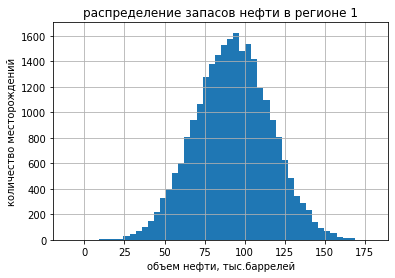

In [53]:
answers_0['predict_product'].hist(bins=50)
plt.title("распределение запасов нефти в регионе 1"); 
plt.xlabel("объем нефти, тыс.баррелей")
plt.ylabel("количество месторождений")
plt.show()

In [54]:
answers_0['predict_product'].describe()

count    25000.000000
mean        92.549362
std         23.417413
min         -9.834307
25%         76.555717
50%         92.687630
75%        108.463616
max        180.192010
Name: predict_product, dtype: float64

        предсказания модели относительно запасов в регионе 2:

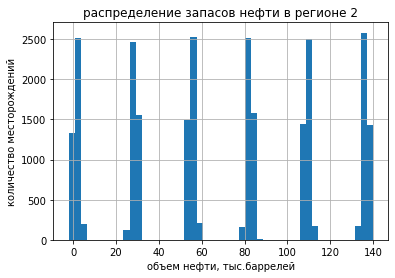

In [55]:
answers_1['predict_product'].hist(bins=50)
plt.title("распределение запасов нефти в регионе 2"); 
plt.xlabel("объем нефти, тыс.баррелей")
plt.ylabel("количество месторождений")
plt.show()

In [56]:
answers_1['predict_product'].describe()

count    25000.000000
mean        69.280019
std         45.819890
min         -2.066353
25%         28.689663
50%         79.987224
75%        109.351179
max        139.906443
Name: predict_product, dtype: float64

        предсказания модели относительно запасов в регионе 3:

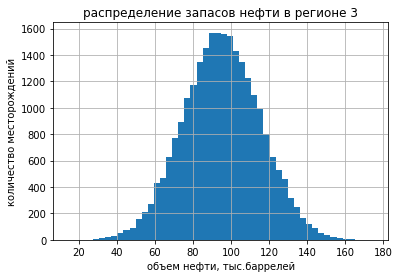

In [57]:
answers_2['predict_product'].hist(bins=50)
plt.title("распределение запасов нефти в регионе 3"); 
plt.xlabel("объем нефти, тыс.баррелей")
plt.ylabel("количество месторождений")
plt.show()

In [58]:
answers_2['predict_product'].describe()

count    25000.000000
mean        95.098599
std         20.175789
min         14.590694
25%         81.398949
50%         94.929589
75%        108.821916
max        174.573336
Name: predict_product, dtype: float64

На графиках трёх регионов мы видим, что в достаточном количестве встречаются месторождения с запасом более 120 тыс.баррелей.

Теперь нас не пугает недостаточное среднее. Главное, чтоб модель верно строила прогноз.

# 4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

В этом шаге мы:


Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.


        Функция для расчёта прибыли - сумма всех тысяч баррелей нефти предсказанная (или реальная), которые может добыть кампания, разрабатывая известные месторождения, умноженная на стоимость одной тысячи баррелей из чего вычитается бюджет. 

In [59]:
def general_profit(summ_barrels):
    return(int((sum(summ_barrels) * cost_1000) - budget))

        Функцимя для расчета средней прибыли:

In [60]:
def general_mean_profit(series):
    return(series.mean())

__4.1.__

Выберем скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины.


В шаге три мы обговорили, что бюджет на разработку 1 скважины = 50млн.руб., а бюджет на весь регион - 10 млрд.руб., то есть на разработку 200 скважин.

        топ 200 скважин района 1:

In [61]:
top_0 = sorted(pred_0, reverse=True)

In [62]:
top_0 = top_0[0:200]

        топ 200 скважин района 2:

In [63]:
top_1 = sorted(pred_1, reverse=True)

In [64]:
top_1 = top_1[0:200]

        топ 200 скважин района 3:

In [65]:
top_2 = sorted(pred_2, reverse=True)

In [66]:
top_2 = top_2[0:200]

__4.2.__ 

Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.

        сумма объема сырья региона 1:

In [67]:
summ_0 = sum(top_0)
summ_0

31034.78780509359

        сумма объема сырья региона 2:

In [68]:
summ_1 = sum(top_1)
summ_1

27755.76198279395

        сумма объема сырья региона 3:

In [69]:
summ_2 = sum(top_2)
summ_2

29943.443110391756

Самый перспективный регион - первый, далее - третий и замыкает - второй.

__4.3.__

Рассчитаем прибыль для полученного объёма сырья произведением суммы запасов в 200 сткважинах на стоимость тысячи баррелей (в рублях).

        прибыль в регионе 1:

In [70]:
sum_profit_0 = general_profit(top_0)
sum_profit_0

3965654512

        прибыль в регионе 2:

In [71]:
sum_profit_1 = general_profit(top_1)
sum_profit_1

2490092892

        прибыль в регионе 3:

In [72]:
sum_profit_2 = general_profit(top_2)
sum_profit_2

3474549399

Теоретически: Самый перспективный регион - первый, далее - третий и замыкает - второй.

С каким регионом будет работать кампания - узнаем в шаге 5.

# 5. Подсчёт рисков и прибыли для каждого региона

Общий план таков:

Согласно Центральной Предельной Теореме случайная выборка имеет свойства генеральной совокупности.

Поэтому методом бутстреп мы создадим 1000 случайных выборок по 500 объектов из общего датафрейма, отсортируем датафрейм по предсказанным значениям от большего к меньшему и возьмем из него первые 200 значений "действительного запаса нефти" (НЕ предсказанного, а "таргетного"). 

Посчитаем прибыль и сохраним данные в список ``values``.

Далее найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.


__5.1.__

Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [73]:
def get_values(data):
    values = []
    state = np.random.RandomState(12345)
    for i in range(1000):
        subsampling = data.sample(n=500, replace=True, random_state=state)
        subsampling = subsampling.sort_values(by='predict_product', ascending=False).reset_index(drop=True)
        selected_wells = subsampling.loc[0:wells, 'true_product']      
        profit = general_profit(selected_wells)
        values.append(profit)
    values = pd.Series(values)
    return(values)

Данные, которые мыполучили в шаге 2 - хранятся в датафрейме answers, в столбце 'predict_product' - предсказанные на валидационной выборке значения запасов нефти, в столбце 'true_product' - таргетные значения.

In [74]:
values_0 = get_values(answers_0)

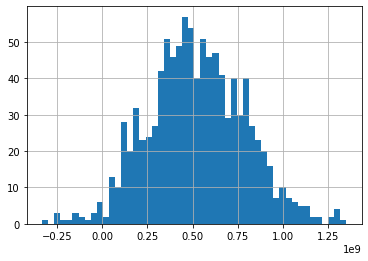

In [75]:
values_0.hist(bins=50)

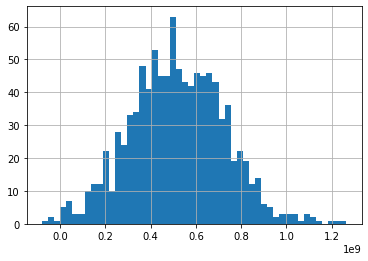

In [76]:
values_1 = get_values(answers_1)
values_1.hist(bins=50)

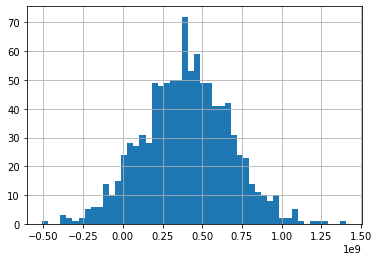

In [77]:
values_2 = get_values(answers_2)
values_2.hist(bins=50)

Оценивая распределеиня, можно сказать, что наша модель справляется, причем оптимальней всего - в регионе 2, где rmse = 0.8, самая низкая.

__5.2.__

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

Автоматизируем процесс, что позволит сократить объем кода и его дубликацию:

In [78]:
def get_conf_int(values):
    lover = int(values.quantile(0.025))
    upper = int(values.quantile(0.975))
    mean_prof = int(values.mean())
    median_prof = int(values.median())
    confidence_interval = st.t.interval(alpha = 0.95, df=(len(values)-1),
                                        loc=values.mean(), scale=values.sem())
    print('Средняя выручка: ', mean_prof)
    print('Медиана распределения выручки: ', median_prof)
    print('2,7% - квантиль: ', lover)
    print('97.5% - квантиль: ', upper)
    print('Доверительный интервал: ', confidence_interval)

In [79]:
print('Регион 1')
print()
get_conf_int(values_0)

Регион 1

Средняя выручка:  522145480
Медиана распределения выручки:  510670210
2,7% - квантиль:  43923596
97.5% - квантиль:  1053821845
Доверительный интервал:  (505590763.1923125, 538700196.8656875)


In [80]:
print('Регион 2')
print()
get_conf_int(values_1)

Регион 2

Средняя выручка:  517699508
Медиана распределения выручки:  511243103
2,7% - квантиль:  119413699
97.5% - квантиль:  927845145
Доверительный интервал:  (504751046.12018603, 530647970.07581395)


In [81]:
print('Регион 3')
print()
get_conf_int(values_2)

Регион 3

Средняя выручка:  398833408
Медиана распределения выручки:  400096295
2,7% - квантиль:  -132884013
97.5% - квантиль:  939705413
Доверительный интервал:  (381912293.5958873, 415754524.0501127)


__5.3.__

__Вывод:__ предложим регион для разработки скважин и обоснуем выбор.

Сразу отказываемся от разработки третьего региона, т.к. минимум 2,7% риск, что компания понесет убытки, не смотря на то, что третий регион - на втором месте по запасам сырья. Причем rmse модели третьего региона самое высокое = 40

Выбор стоит между двумя регионами: 1 регионом и вторым. 

Хоть в первом регионе средняя выручка и выше = 522млн.руб., против средней выручки второго региона = 517млн.руб., разницы между ними составляет 4 млн. руб (средние прибыли почти равны, 4 млн. не имееют большого значения, когда говоряят о миллиардах), 

но во втором регионе 2,7% - квантиль равен  119млн.руб., второй регион почти безъубыточен, в то время как в первом 2,7% - квантиль равен  43млн.руб, разница в 76 млн.руб.

Рекомендация к выбору второго региона для разработки.

Таким образом, на практике был выбран второй регион, который с самым низким запасом сырья, НО самой точной моделью, ее rmse = 0.8, потив первого региона = 37 и третьего = 40. Третий стал самым убыточным. То есть можно сказать, что точность предсказания важней запасов сырья, т.к. будут выбраны месторождения с большим запасом сырья с бОльшей вероятность.